In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import ParameterSampler
import itertools
from joblib import Parallel, delayed

In [3]:
df =  pd.read_csv("../../notebooks/Data_processing/processed_data_final.csv")

In [4]:
df.head()


,utc_timestamp,DE_solar_generation_actual,DE_wind_generation_actual,DE_load_actual_entsoe_transparency,DE_LU_price_day_ahead
0,2015-01-01 07:00:00+00:00,71.0,10208.0,41133.0,NaN
1,2015-01-01 08:00:00+00:00,773.0,10029.0,42963.0,NaN
2,2015-01-01 09:00:00+00:00,2117.0,10550.0,45088.0,NaN
3,2015-01-01 10:00:00+00:00,3364.0,11390.0,47013.0,NaN
4,2015-01-01 11:00:00+00:00,4198.0,12103.0,48159.0,NaN


In [5]:
# Convertir la columna 'utc_timestamp' a formato de fecha y establecerla como índice
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True)
df.set_index('utc_timestamp', inplace=True)


In [6]:
# Llenar valores nulos con interpolación (puedes ajustar el método si es necesario)
df.fillna(method='ffill', inplace=True)

/var/folders/54/ddzf5nq5133324qrz2cb0_gc0000gn/T/ipykernel_66683/1168315095.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [7]:
# Seleccionar la columna objetivo: por ejemplo 'DE_load_actual_entsoe_transparency'
target_variable = 'DE_load_actual_entsoe_transparency'
series = df[target_variable].dropna()

# Normalización de los datos utilizando StandardScaler
scaler = StandardScaler()
scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

# Reconstruir la serie con los valores escalados
scaled_series = pd.Series(scaled_series.flatten(), index=series.index)


subset_start_time = pd.to_datetime('2015-01-01 00:00:00').tz_localize('UTC')
subset_end_time = pd.to_datetime('2017-01-01 00:00:00').tz_localize('UTC')
scaled_series = scaled_series[subset_start_time:subset_end_time]


# Dividir en datos de entrenamiento y prueba
start_time = pd.to_datetime('2016-12-01 00:00:00').tz_localize('UTC')
train_data = scaled_series[:start_time]
test_data = scaled_series[start_time:]


In [8]:
# Define the parameter space for RandomizedSearchCV
param_grid = {
    'order': list(itertools.product(range(0, 3), repeat=3)),  # (p, d, q) with values between 0 and 2
    'seasonal_order': [(1, 1, 1, 24), (1, 1, 1, 168)],  # Seasonal order (weekly or daily cycle)
}


In [9]:
# Use ParameterSampler to sample random combinations
n_iter = 20  # Define how many combinations you want to test
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

In [10]:
# Function to fit SARIMAX for a given parameter set
def fit_sarimax(params, train_data):
    try:
        model = SARIMAX(train_data, order=params['order'], seasonal_order=params['seasonal_order'])
        model_fit = model.fit(disp=False)
        return model_fit.aic, params, model_fit
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return np.inf, params, None

# Run parallel processing to fit multiple models simultaneously
# Run parallel processing to fit multiple models with limited CPU cores (e.g., 2 cores)
results = Parallel(n_jobs=10)(delayed(fit_sarimax)(params, train_data) for params in param_list)

/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/py

In [1]:
# Find the best model
best_result = min(results, key=lambda x: x[0])  # Find the model with the lowest AIC
lowest_aic, best_params, best_model = best_result
print(f'Best SARIMA parameters: {best_params}')
print(f'Best AIC: {lowest_aic}')

NameError: name 'results' is not defined

In [26]:
# Realizar predicciones para un rango de tiempo dado
end_time = pd.to_datetime('2017-01-01 00:00:00').tz_localize('UTC')
predictions = best_model.get_prediction(start=start_time, end=end_time)


Mean Squared Error:  240988418.8018068
Mean Absolute Error:  12268.211696511687


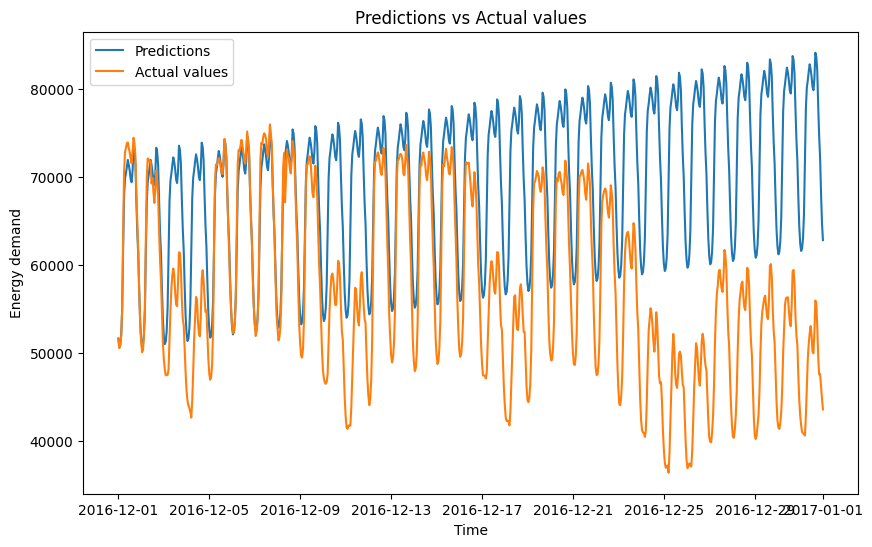

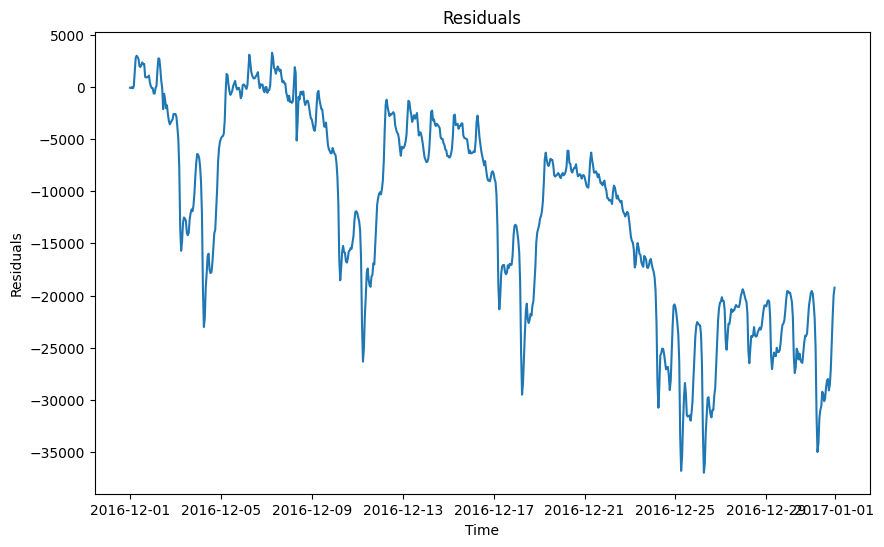

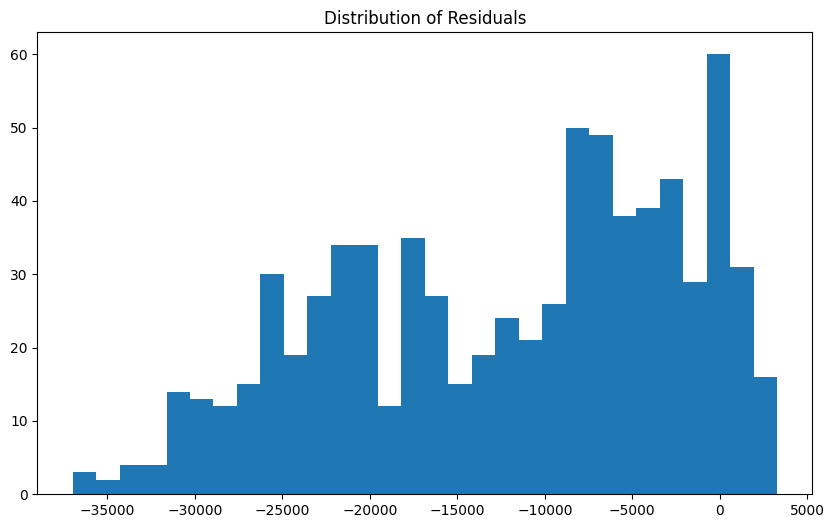

In [27]:
# Asegurarse de que las predicciones y los valores reales tengan la misma longitud
predicted_values = predictions.predicted_mean[:len(test_data[start_time:end_time])]
true_values = test_data[start_time:end_time]

# Invertir la normalización de los datos para las predicciones
predicted_values = scaler.inverse_transform(predicted_values.values.reshape(-1, 1))
true_values = scaler.inverse_transform(true_values.values.reshape(-1, 1))

# Calcular métricas de error
mse = mean_squared_error(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)

print('Mean Squared Error: ', mse)
print('Mean Absolute Error: ', mae)

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(test_data[start_time:end_time].index, predicted_values, label='Predictions')
plt.plot(test_data[start_time:end_time].index, true_values, label='Actual values')
plt.title('Predictions vs Actual values')
plt.xlabel('Time')
plt.ylabel('Energy demand')
plt.legend()
plt.show()

# Graficar residuales del modelo para evaluar el ajuste
residuals = true_values.flatten() - predicted_values.flatten()
plt.figure(figsize=(10, 6))
plt.plot(test_data[start_time:end_time].index, residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Graficar histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.show()